In [2]:
import pandas as pd
pd.options.display.max_columns =200
import numpy as np
from datetime import datetime, timedelta

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import mapclassify
import seaborn as sns


## I. Correlating COVID case statistics with Census Demographic Social Vulnerability
This notebook tests a number of different approaches to correlating COVID statistics with Social Vulnerability (as defined by the CDC Social Vulnerability Index). 

COVID data used was collected by the [New York Times](https://github.com/nytimes/covid-19-data) for cumulative cases by county in the U.S. which is updated daily. 


In [4]:
## data imports
svi = pd.read_csv("data/svi/svi_2018_counties_state_ranked.csv")
covid = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
# counties = gpd.read_file('./data_processing/tl_2019_us_county/tl_2019_us_county.shp')

In [14]:
# convert date to datetime format
covid['dt'] = pd.to_datetime(covid['date'], infer_datetime_format=True)

# create totals for cases and deaths
total_covid = covid.groupby('fips')['cases','deaths'].sum().reset_index()
total_covid['fips'] = total_covid['fips'].astype(int)

<ipython-input-14-32dea894a751>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  total_covid = covid.groupby('fips')['cases','deaths'].sum().reset_index()


In [17]:
## calculating percent ranking for other forms of SVI
svi['RPL_Theme1States'] = svi.groupby('STATE')['SPL_THEME1'].rank(pct=True)
svi['RPL_Theme2States'] = svi.groupby('STATE')['SPL_THEME2'].rank(pct=True)
svi['RPL_Theme3States'] = svi.groupby('STATE')['SPL_THEME3'].rank(pct=True)
svi['RPL_Theme4States'] = svi.groupby('STATE')['SPL_THEME4'].rank(pct=True)

In [24]:
# merge svi and covid counts
total_covid_svi = total_covid.merge(svi[['FIPS','STATE','COUNTY','E_TOTPOP',
                                         'RPL_ThemesStates',
                                         'RPL_Theme1States',
                                         'RPL_Theme2States',
                                        'RPL_Theme3States',
                                        'RPL_Theme4States','geometry']],left_on='fips',right_on='FIPS')

In [72]:
# calculate population normalized cases and deaths
total_covid_svi['cases_pop'] =total_covid_svi['cases']/total_covid_svi['E_TOTPOP']
total_covid_svi['deaths_pop'] =total_covid_svi['deaths']/total_covid_svi['E_TOTPOP']
# calculate case fatalities
total_covid_svi['case_fatality'] = total_covid_svi['deaths']/total_covid_svi['cases']

## I.a Cases/population  versus SVI composite index

Cases/population calculated for each county plotted against the composite social vulnerability index. 


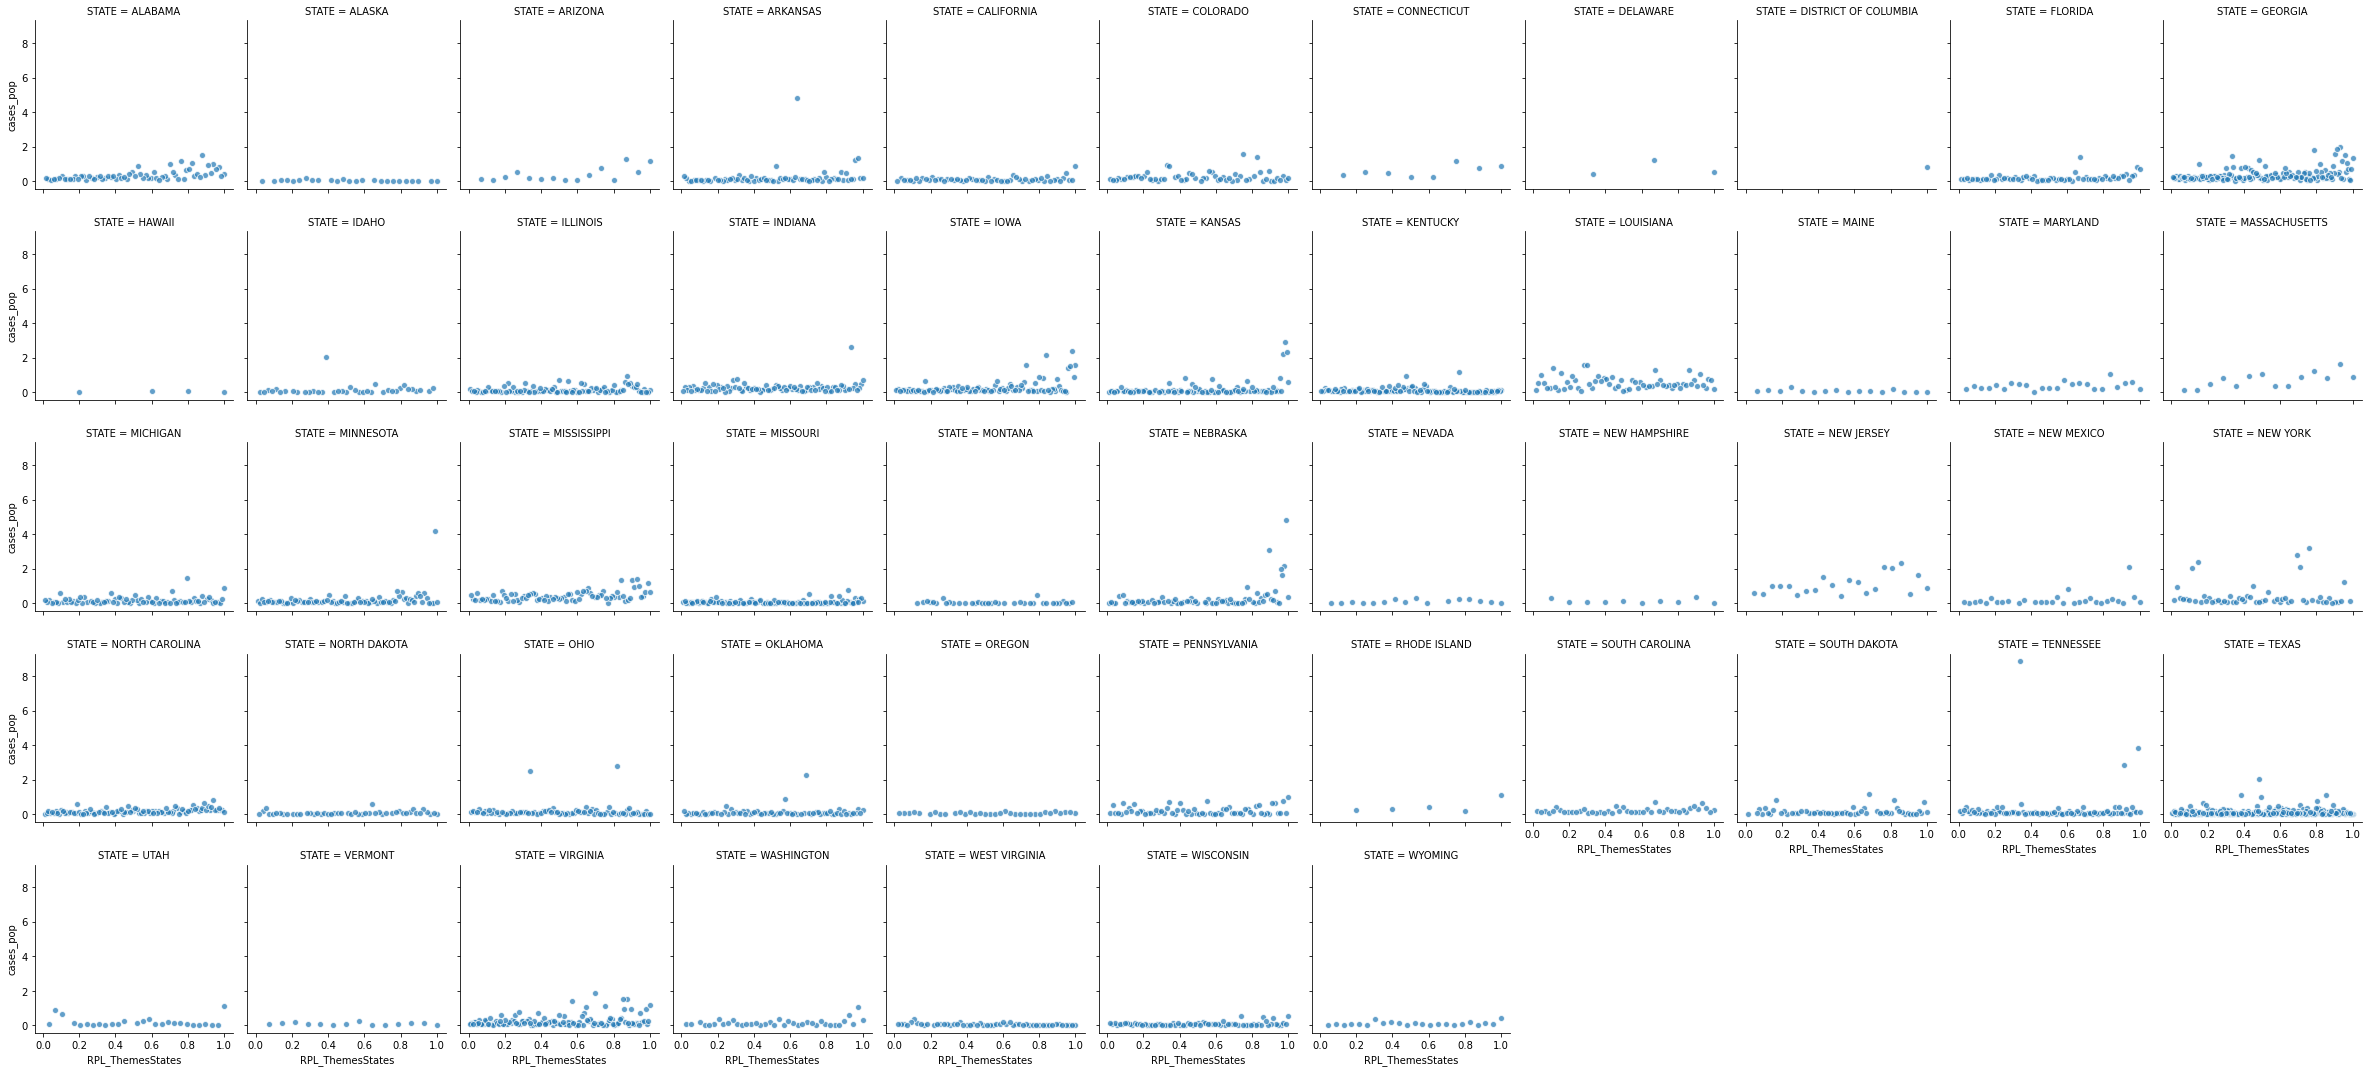

In [90]:
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties_case = all_counties.map(plt.scatter, "RPL_ThemesStates", "cases_pop", alpha=0.7,edgecolor="w")

## I.b Deaths/population versus SVI composite index

deaths/population calculated for each county plotted against the composite social vulnerability index. 


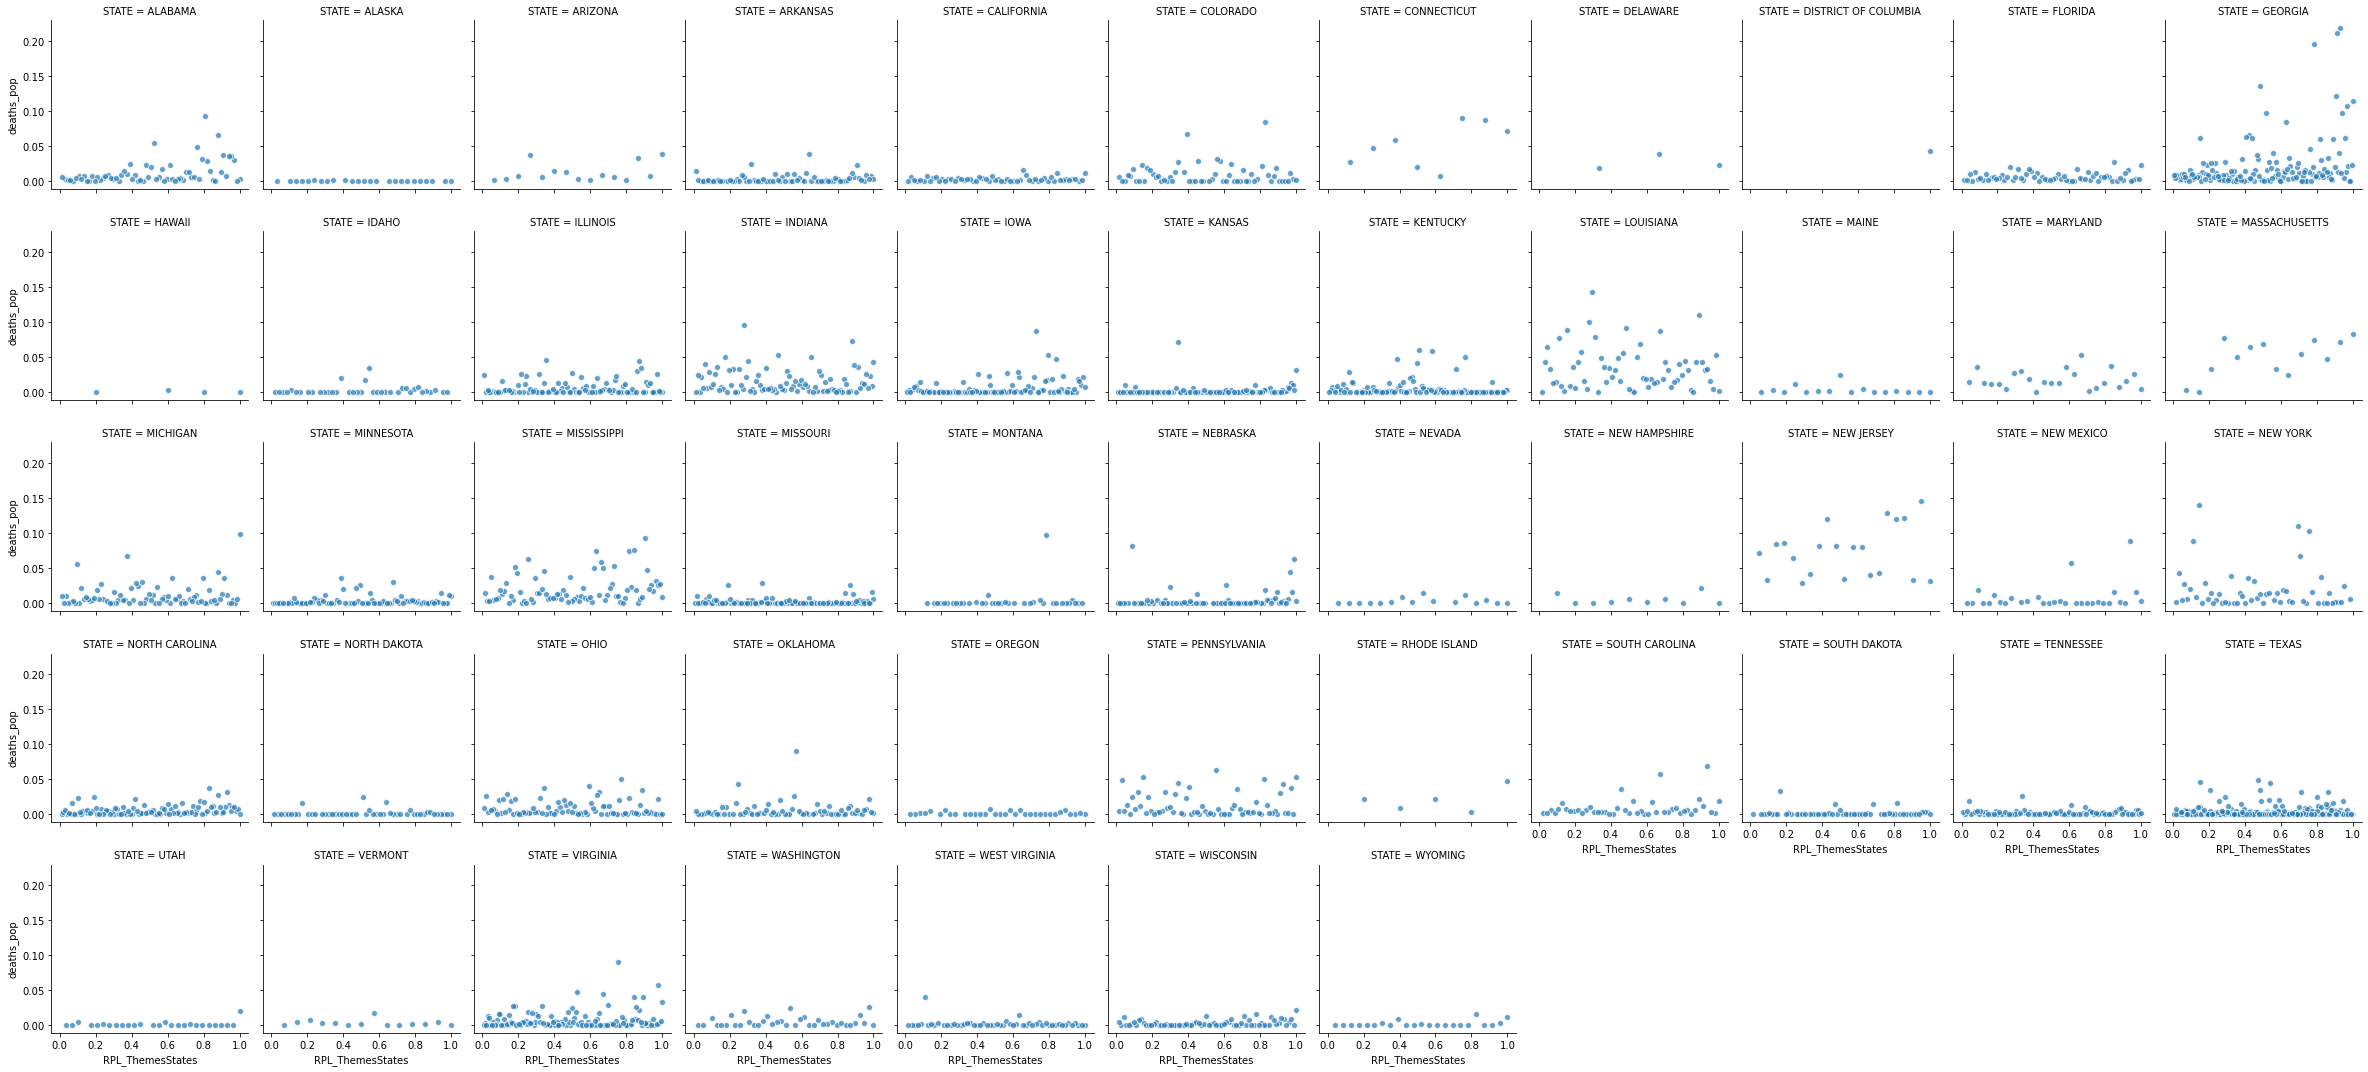

In [91]:
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties_death = all_counties.map(plt.scatter, "RPL_ThemesStates", "deaths_pop", alpha=0.7,edgecolor="w")

## II. Case fatalities versus SVI composite index

Case fatalities (number of deaths / number of cases) calculated for each county plotted against the composite social vulnerability index. 


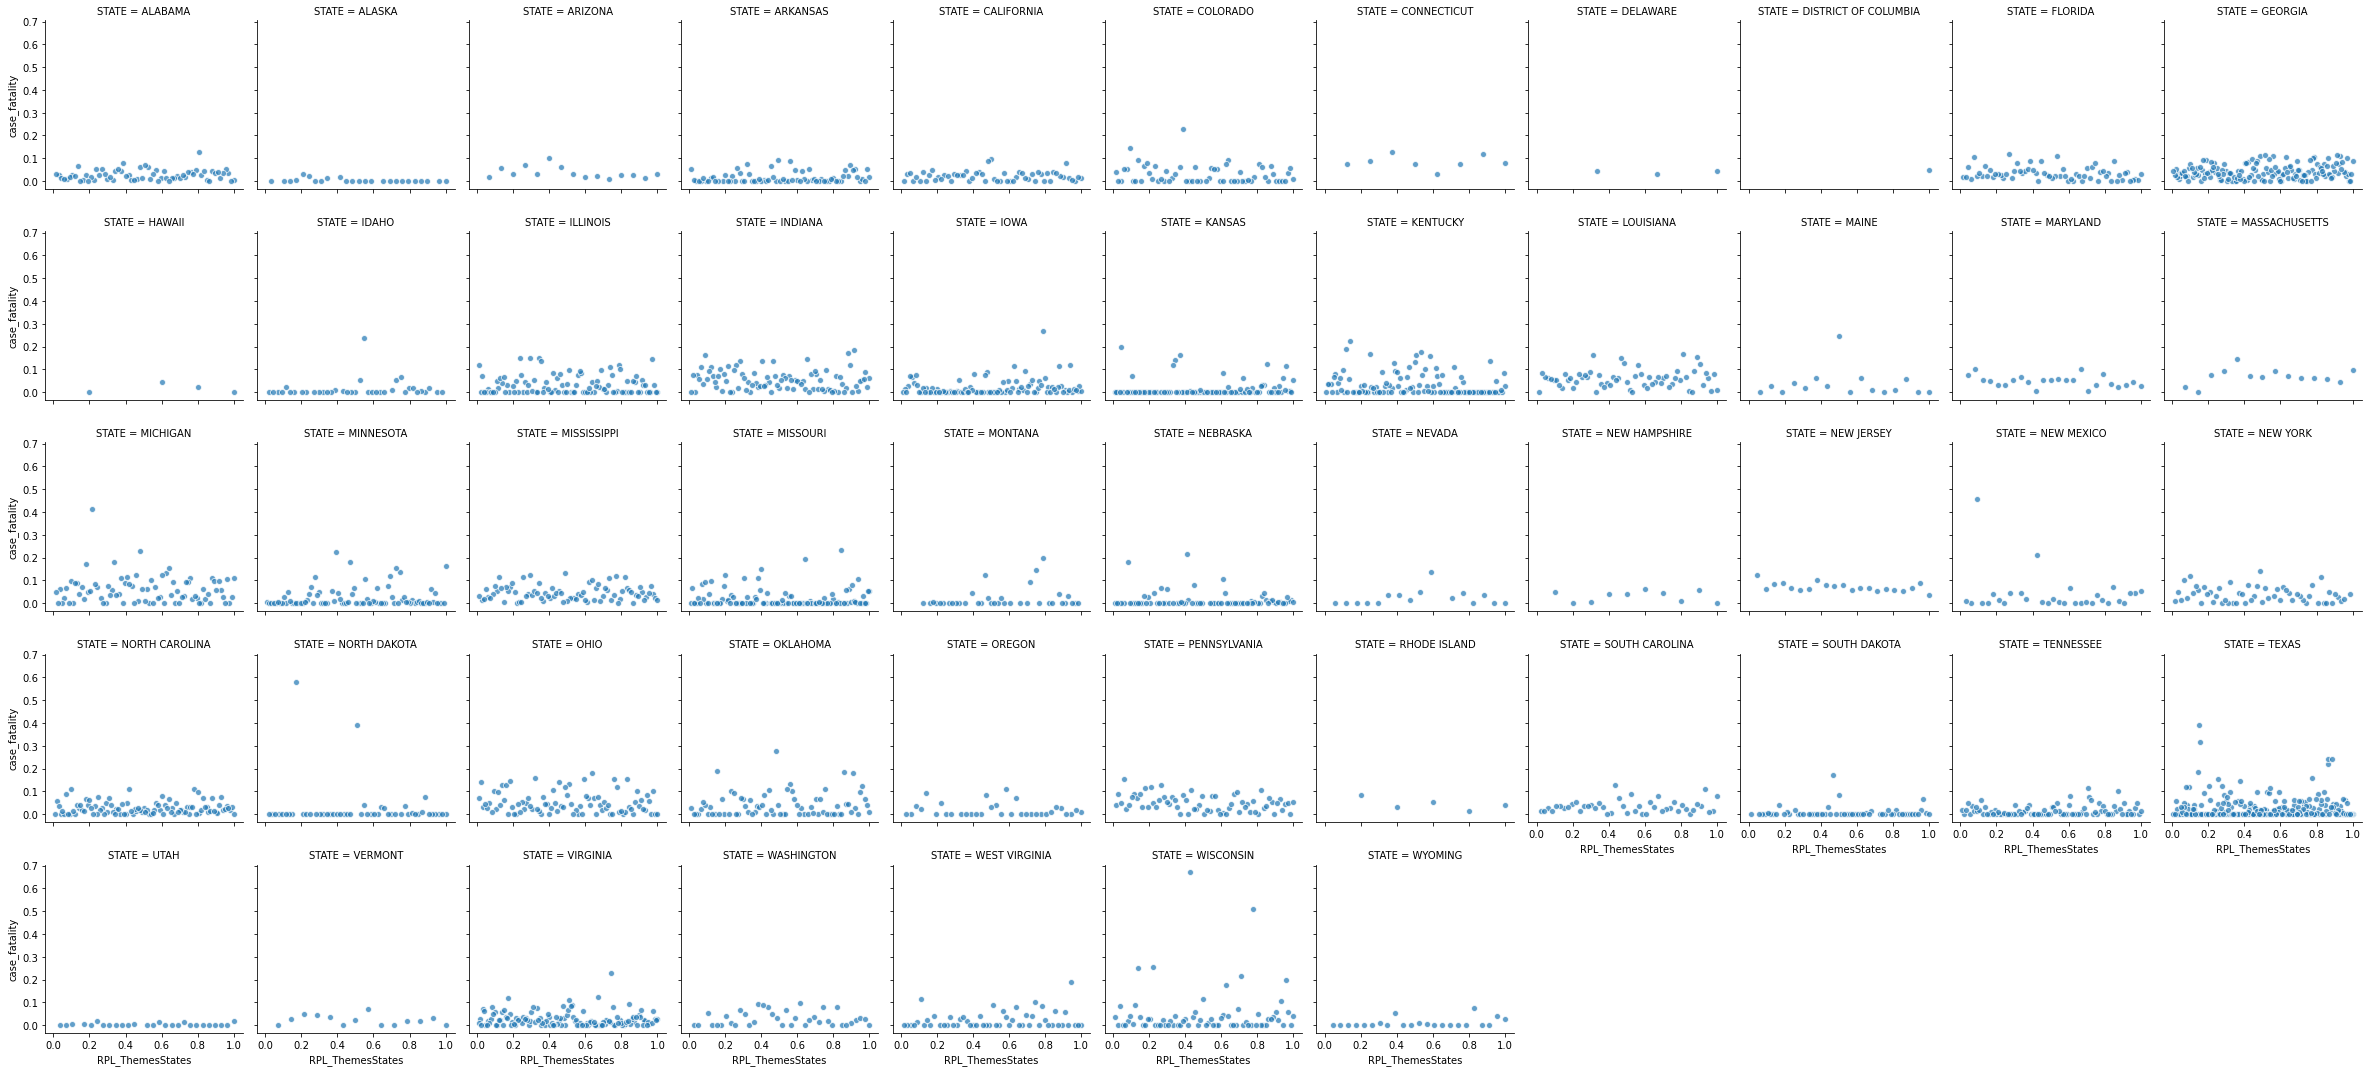

In [83]:
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties = all_counties.map(plt.scatter, "RPL_ThemesStates", "case_fatality", alpha=0.7,edgecolor="w")

## II.a Case fatalities versus SVI composite index for counties with more than 50 cases

Case fatalities (number of deaths / number of cases) calculated for each county plotted against the composite social vulnerability index. The above 50 threshold is drawn from the [methodology](https://precisionforcovid.org/ccvi) used by the Surgo Foundation to validate their COVID vulnerability index.  


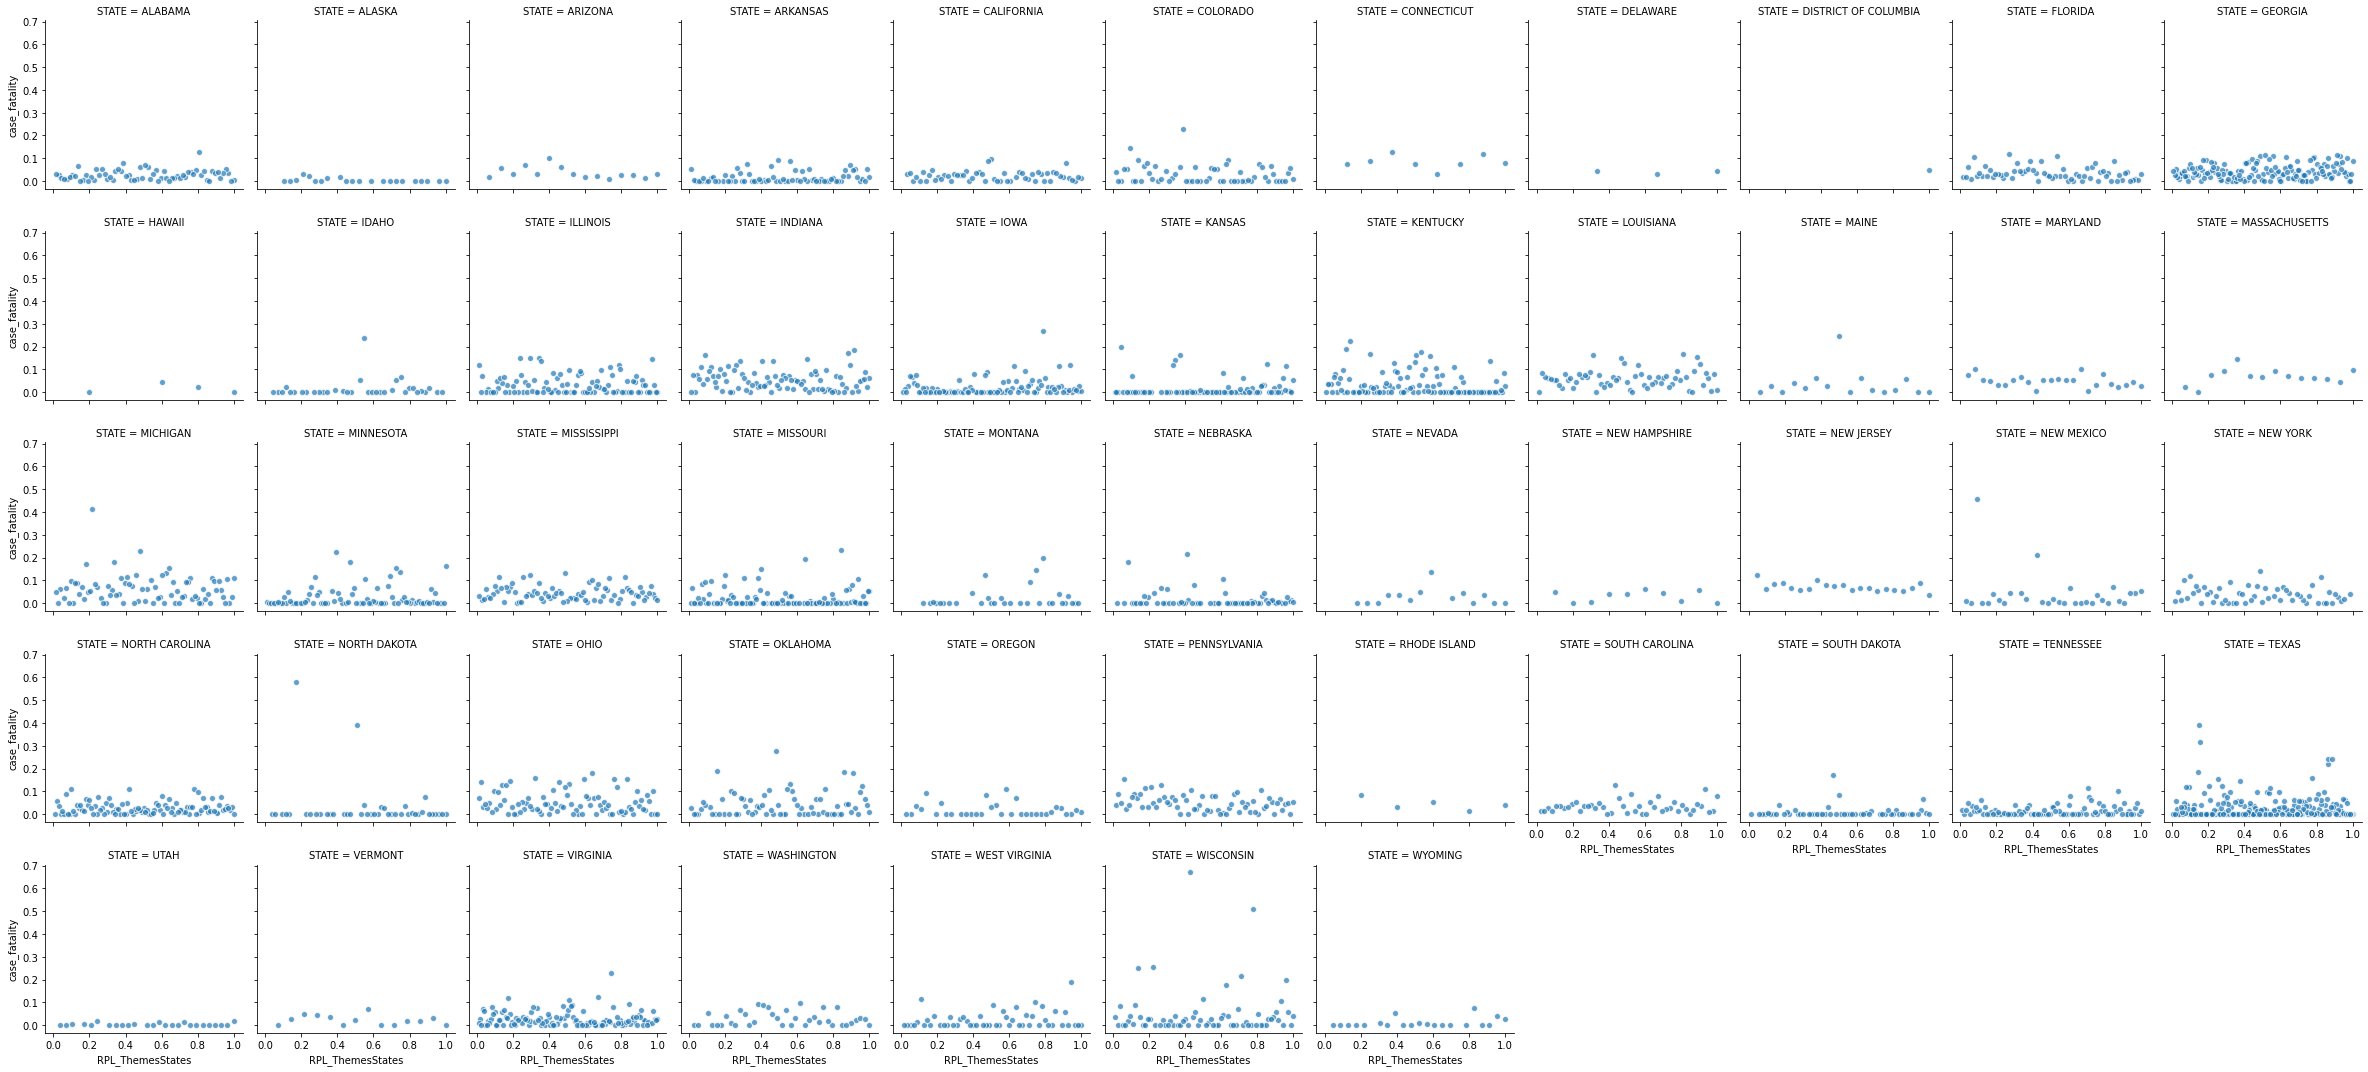

In [82]:
above50 = sns.FacetGrid(total_covid_svi[total_covid_svi['cases']>50],col='STATE',col_wrap=11)
above50 = above50.map(plt.scatter, "RPL_ThemesStates", "case_fatality", alpha=0.7,edgecolor="w")

## III. Case fatalities versus SVI socioeconomic theme 
Case fatalities (number of deaths / number of cases) calculated for each county plotted against the social vulnerability index for socioeconomic variables. 

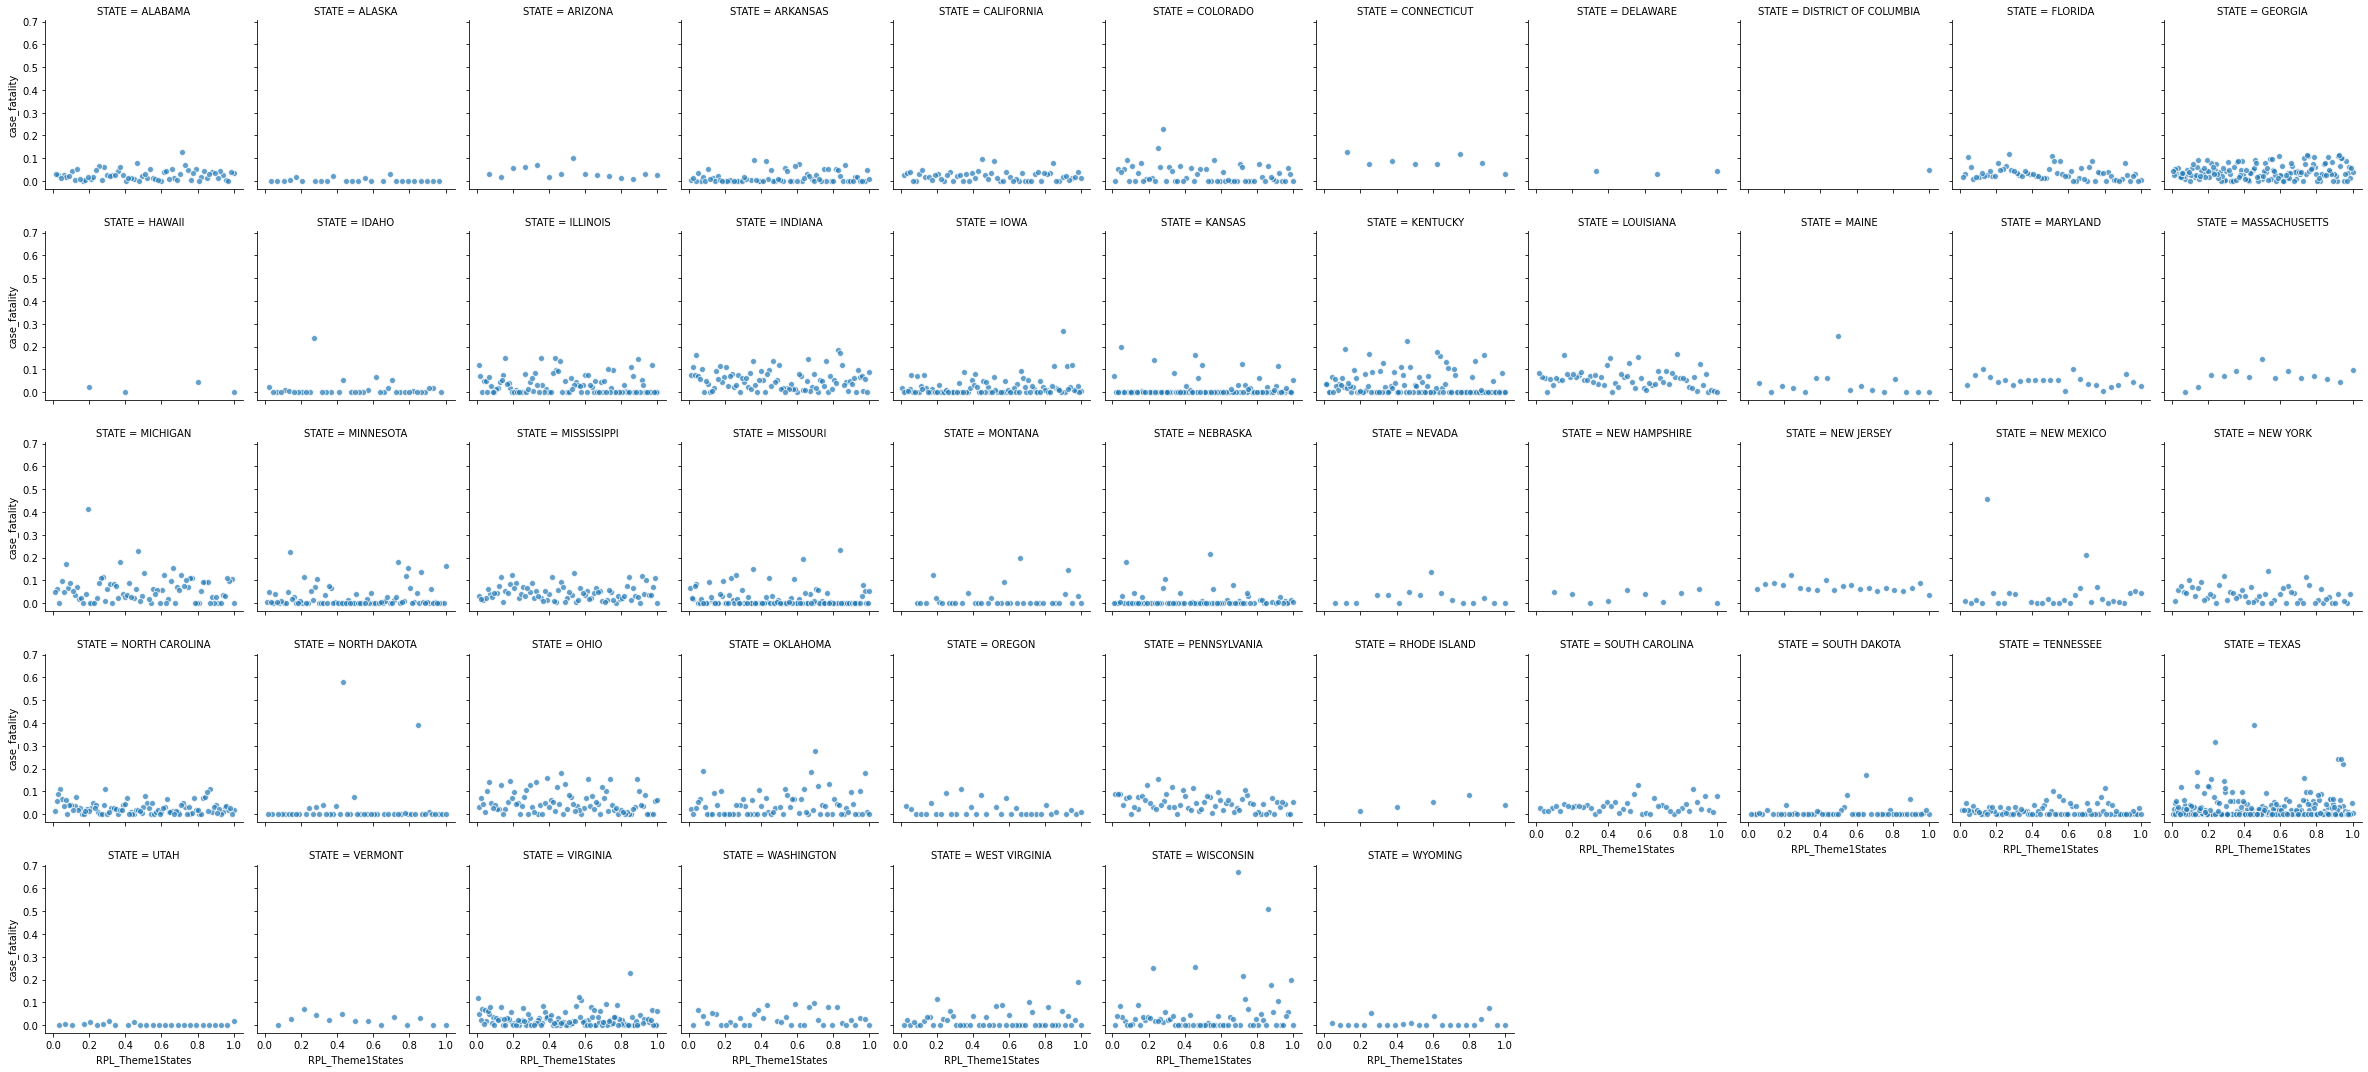

In [84]:
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties1 = all_counties.map(plt.scatter, "RPL_Theme1States", "case_fatality", alpha=0.7,edgecolor="w")

## IV. Case fatalities versus SVI Household Composition theme 
Case fatalities (number of deaths / number of cases) calculated for each county plotted against the social vulnerability index for household composition variables. 

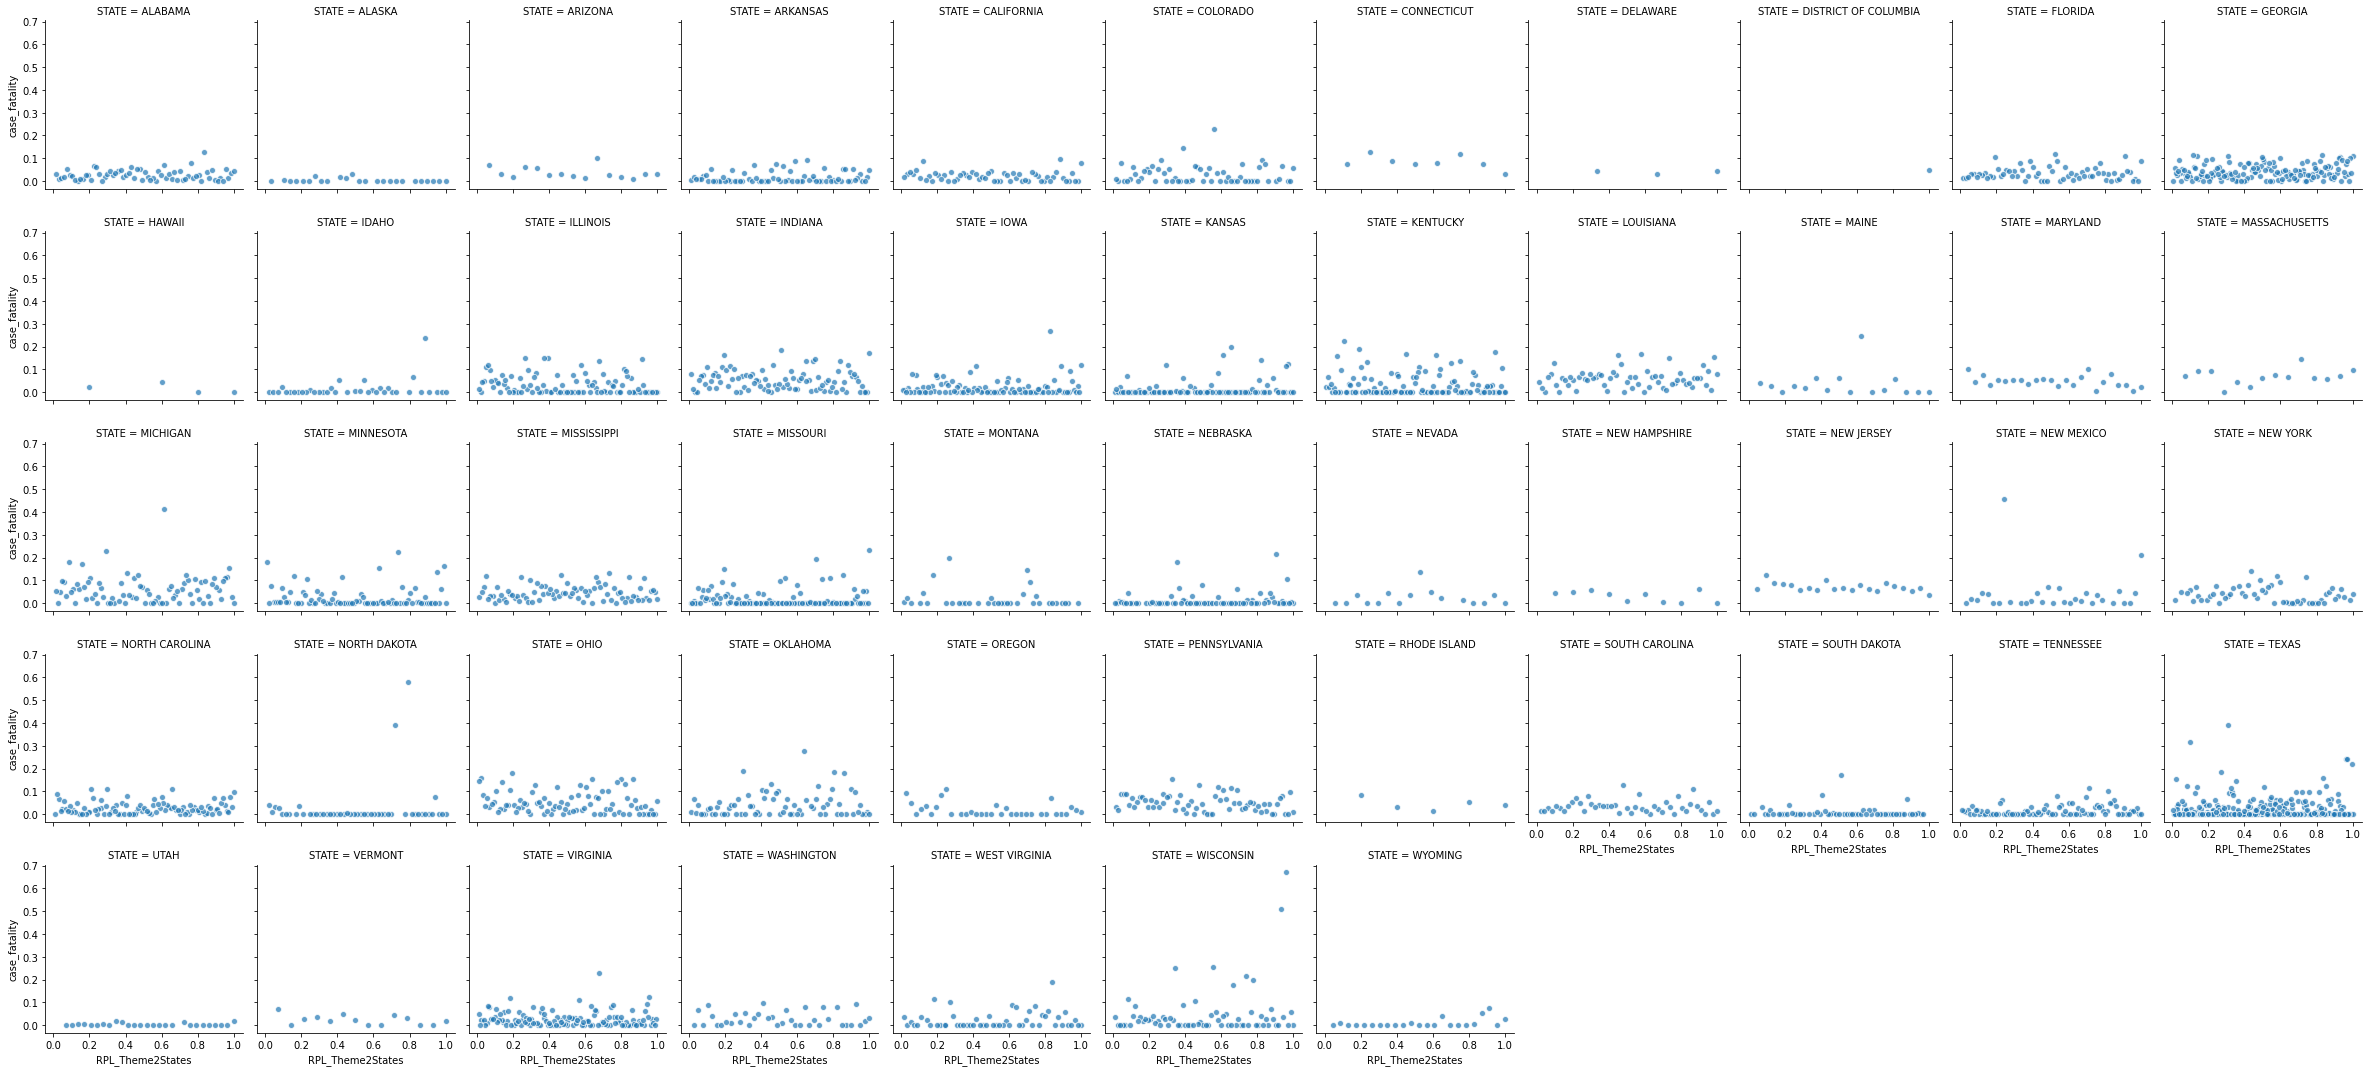

In [85]:
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties2 = all_counties.map(plt.scatter, "RPL_Theme2States", "case_fatality", alpha=0.7,edgecolor="w")

## V. Case fatalities versus SVI Minority Status theme 
Case fatalities (number of deaths / number of cases) calculated for each county plotted against the social vulnerability index for minority status variables. 

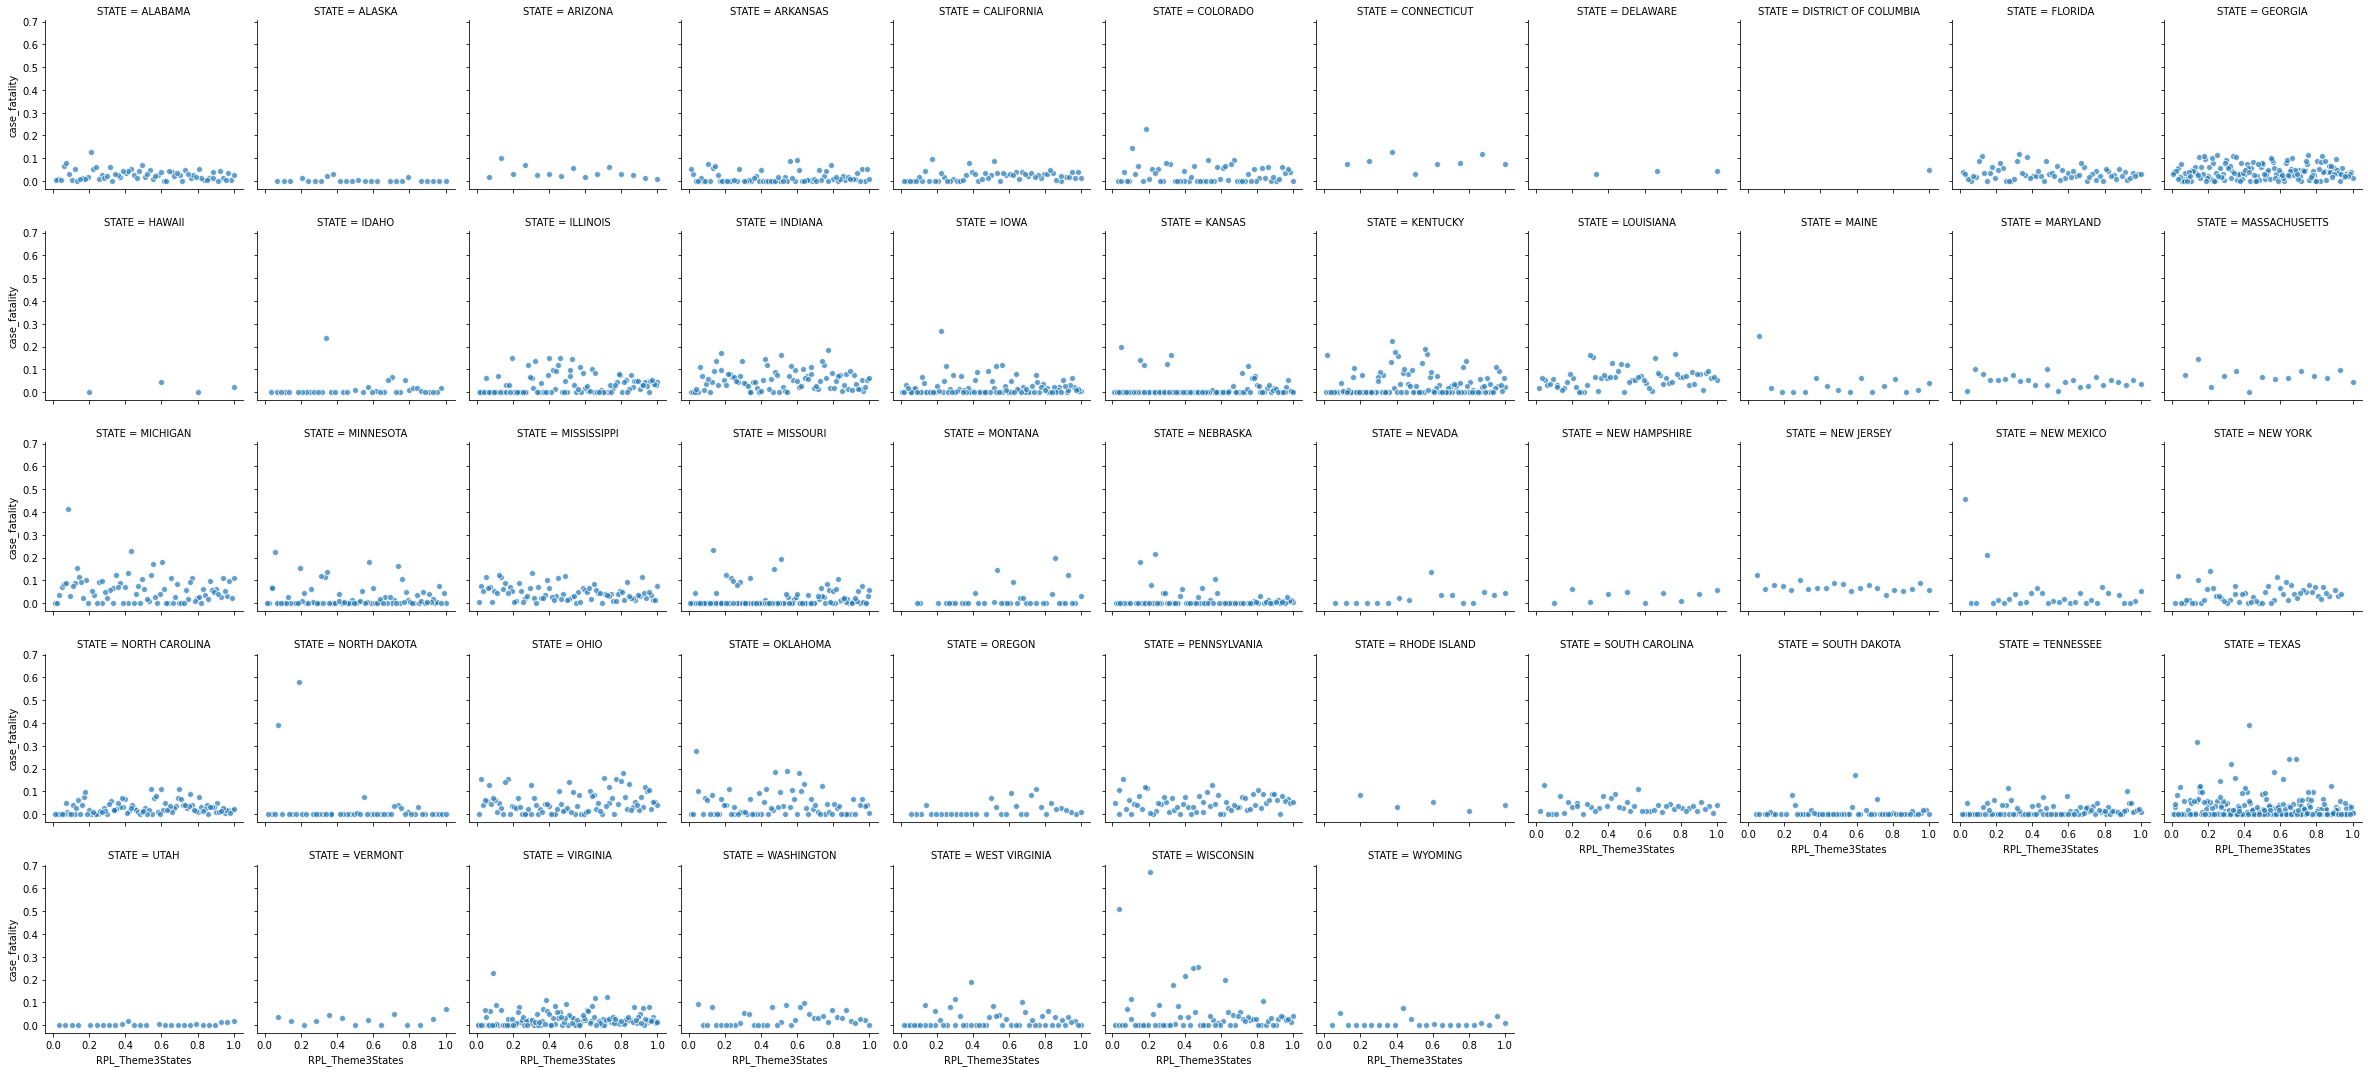

In [87]:
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties3 = all_counties.map(plt.scatter, "RPL_Theme3States", "case_fatality", alpha=0.7,edgecolor="w")

## VI. Case fatalities versus SVI Housing Type theme 
Case fatalities (number of deaths / number of cases) calculated for each county plotted against the social vulnerability index for housing type variables. 

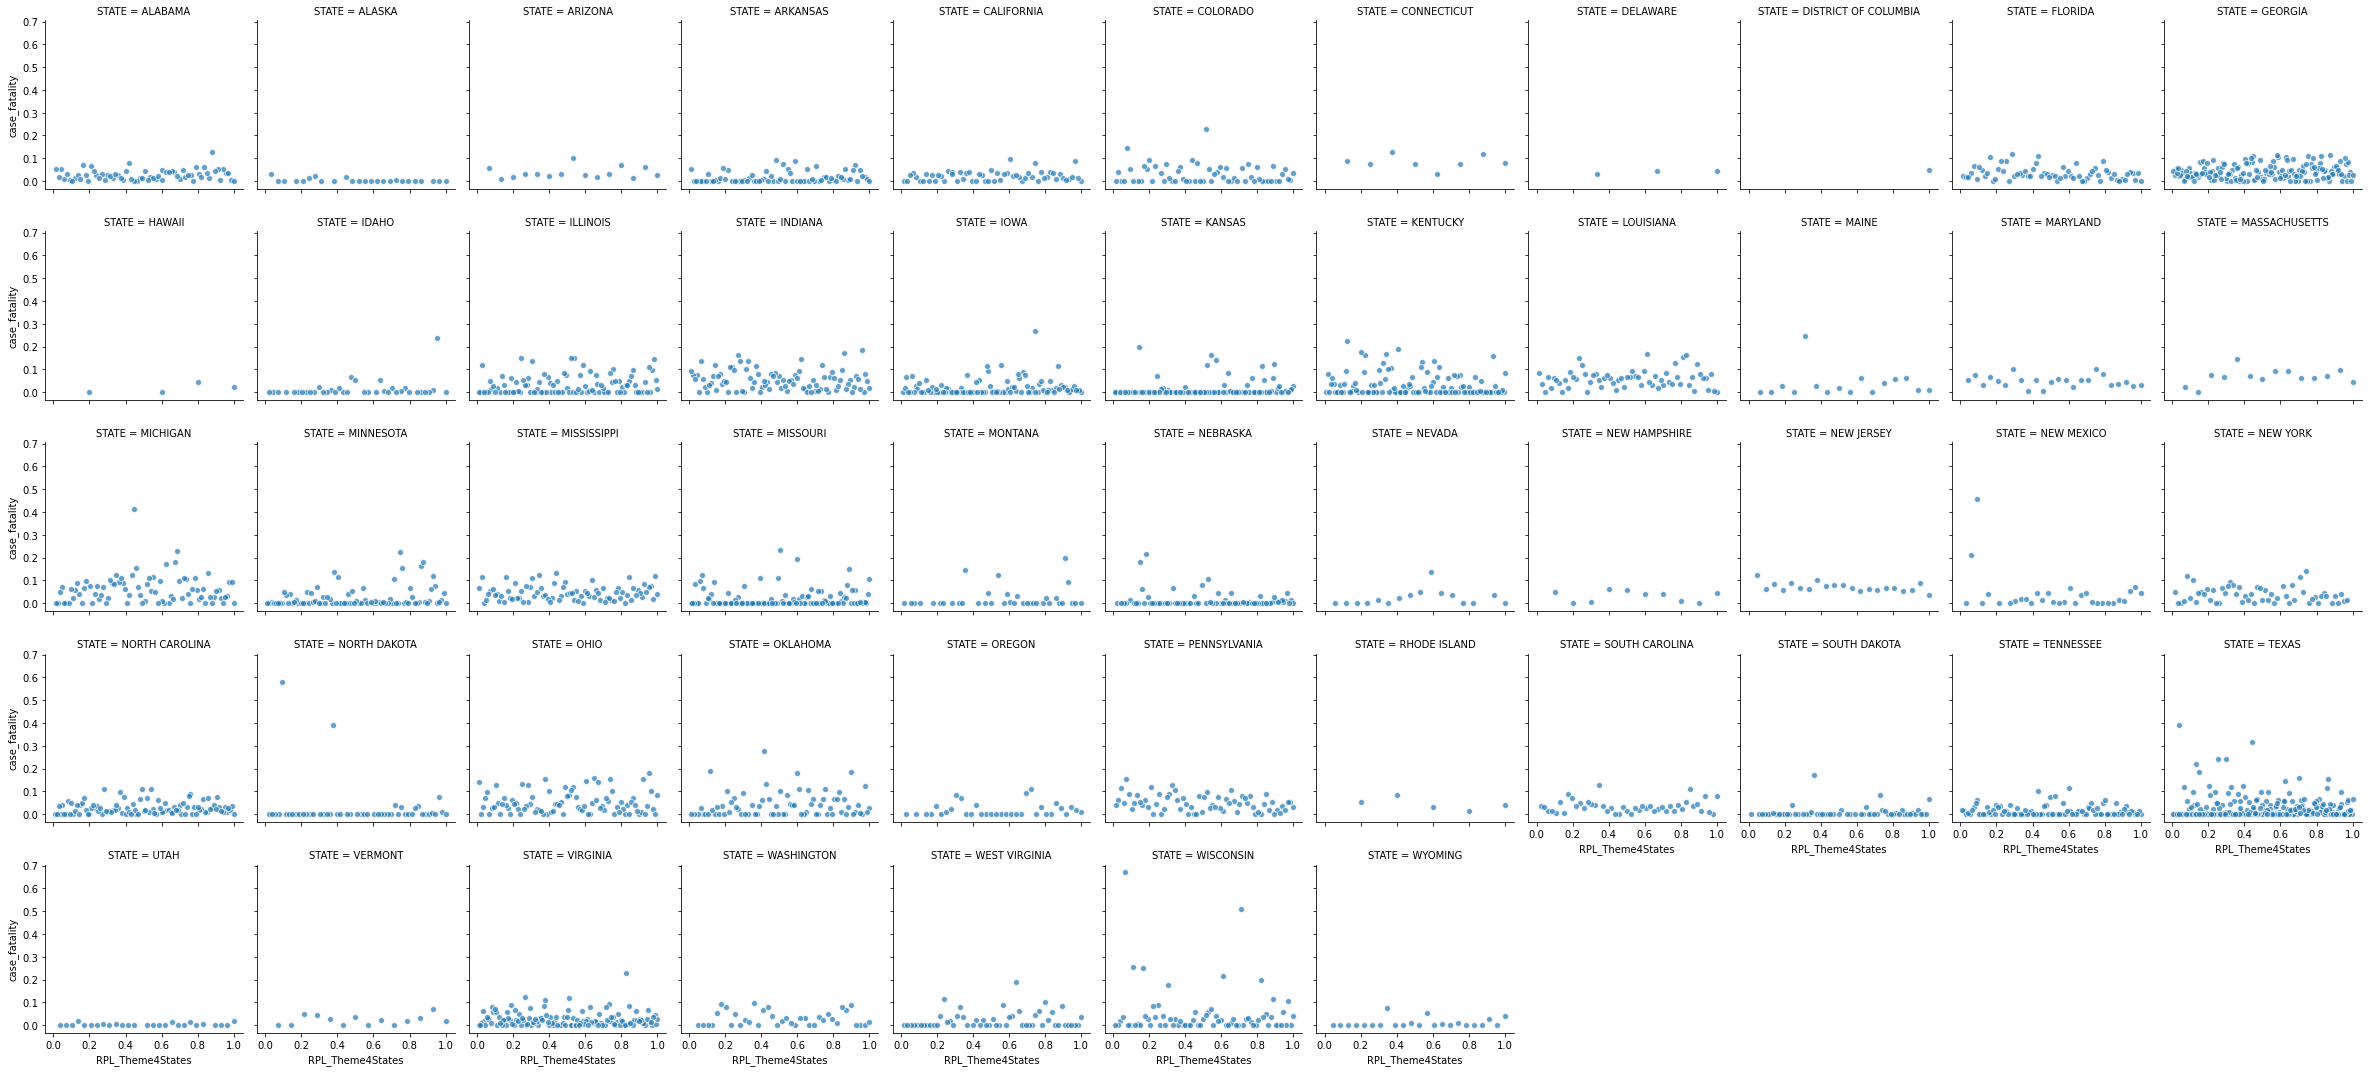

In [88]:
all_counties = sns.FacetGrid(total_covid_svi,col='STATE',col_wrap=11)
all_counties4 = all_counties.map(plt.scatter, "RPL_Theme4States", "case_fatality", alpha=0.7,edgecolor="w")